In [1]:
# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None


In [2]:
# CSVファイルからデータを読み込む
dataset_base = pd.read_csv("./baseball_salary_preprocessed.csv")
dataset_base.head()

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,0.308,143,651,556,171,23,92,13,83,4,113,2,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,0.271,138,629,565,153,14,56,8,32,1,107,30,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,0.290,143,679,565,164,8,60,35,89,15,120,6,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,0.265,116,405,344,91,27,78,0,50,8,111,0,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,0.292,100,288,243,71,9,48,2,40,1,56,0,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [3]:
# 列の抜き出し
dataset = dataset_base[['推定年俸', '打点', '年数', '打率', '本塁打', '球団勝率']]

# 列名をリネームする
dataset = dataset.rename(columns={'推定年俸': 'salary', '打点': 'points', \
    '年数': 'years_exp', '打率': 'batting', '本塁打': 'homerun', '球団勝率': 'team_win'})
dataset.head()

,salary,points,years_exp,batting,homerun,team_win
0,21000,92,11,0.308,23,0.633
1,19000,56,7,0.271,14,0.633
2,14000,60,5,0.290,8,0.633
3,11500,78,7,0.265,27,0.633
4,11000,48,20,0.292,9,0.633


線形回帰モデルの概要
「打点から推定年俸を予測する」ことを考えてみます。まずは打点と推定年俸との関係性を散布図で確認してみましょう。

<Axes: xlabel='points', ylabel='salary'>

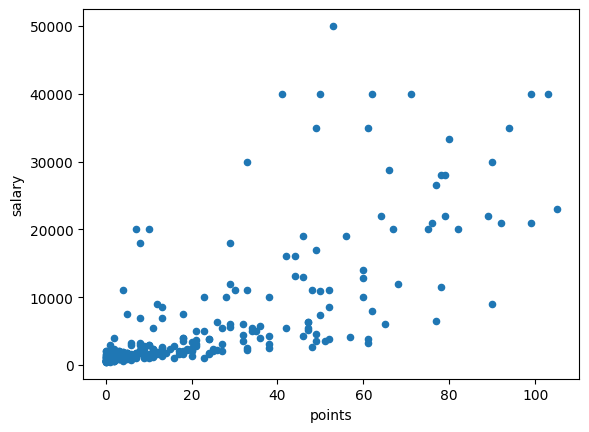

In [4]:
# 打点と推定年俸の散布図
dataset.plot(kind='scatter', x='points', y='salary')

ばらつきはありますが、右肩上がりの関係性が見えます。以下のようなイメージです。このように関係性を直線で表したモデルを 線形回帰モデル と呼びます
線形回帰モデルは直線のグラフなので一次関数で表現できます。 y=ax+bといった式で表される関数
このモデルの最適なパラメータθの値を実際のデータから求めることが、線形回帰モデルの機械学習ということになります。
すなわち すべての「誤差＝実際の値ー予測した値」の合計 が最小になるように、パラメータθの値を決めれば良い、ということになります。
ただし、誤差にはプラスとマイナスがあるため、相殺されないよう 誤差の2乗を合計する 方法が一般的です。このように、誤差の2乗の合計を最小にするようにパラメータを決める方法を 最小二乗法 と呼びます。


目的関数
モデルの最適なパラメータを求めるための式を 目的関数 や 損失関数 と呼びます。このコースでは 目的関数 に統一します

確率的勾配降下法
確率的勾配降下法ではデータセットの中からランダムに1個のデータを選んでパラメータを更新します。またランダムに複数個のデータを選択してパラメータを更新する方法もあり、こちらはバッチ確率的勾配降下法と呼ばれます
最適なパラメータを効率よく求める方法は、とくにパラメータ数の多いディープラーニングにとって重要なテーマであり、多くの手法が研究されています。例として、以前の重みの更新を考慮に入れたMomentum SGDやAdaGrad、RMSprop、Adamなどがあります。

機械学習のプログラムの流れ
それでは実際に機械学習のプログラミングを行っていきましょう。一般的な機械学習のプログラムは以下のような流れになります。

1,データの読み込み
2,データの前処理
3,データの分割（学習データ／検証データ／テストデータ）
4,アルゴリズムの選択
5,学習の実施
6,検証データによる評価
7,チューニング、モデル同士の比較（4～7を繰り返す）
8,モデルの選定
9,テストデータによる最終評価

データの分割の概要
機械学習ではデータセットを「学習データ／検証データ／テストデータ」の3種類に分けて使用します。

1,データセットを 機械学習用データ と テストデータ に分けます。比率は7:3～8:2ぐらい、分け方はランダム（無作為）に抽出するのが一般的です。
2,機械学習用データを、さらに 学習データ と 検証データ に分割します。こちらも比率は7:3～8:2ぐらい、分け方はランダムが一般的です。

それぞれのデータの使用用途は以下のとおりです。

学習データ：機械学習のモデルに学習させるデータ
検証データ：学習したモデルの性能を評価するために使用するデータ
テストデータ：一連のモデルの構築作業（学習／チューニング／モデル同士の比較）が済んだあと、最終的なモデルの性能を評価するために使用するデータ

機械学習は、一連のモデルの構築作業（学習／チューニング／モデル同士の比較）を繰り返します。このことで、学習データの特徴はもちろんのこと、検証データで「学習したモデルの性能を評価」して、チューニングなどを行うため、 検証データの特徴も少なからずモデルに反映 されてしまいます。
機械学習で得たいのは、手元にある特定のデータに対する性能が高いモデルではなく、 一般的なデータに対する性能が高いモデル です。この性能を 汎化性能 と呼びます。手元にないデータを再現するために、データの一部を テストデータ として分けておき、モデルの汎化性能を確認します。

ランダムとは
ランダムとは「無作為。規則性が無く予測できない状態」です。
乱数生成器に設定値を与えると、毎回同じパターンの乱数を発生させることができます。この設定値のことを シード（seed：種）、あるいは ランダムシード と呼びます。

ランダムシードは、プログラミングで乱数を使う際に「再現性を持たせたい」、という場合に使用します。Pythonの各種ライブラリでは random_state という引数名でランダムシードを指定できる場合が多いです。

たとえば random_state=0 などのように同じ数値を指定することで、毎回同じ乱数が生成されます。以下は、train_test_split という関数でデータを分割する際に、ランダムシードを指定する例です

ホールドアウト法
単純に割合でデータを「学習データ／検証データ／テストデータ」に分割する方法をホールドアウト法と呼びます

クロスバリデーション（交差検証）
前記の「複数回のホールドアウト法」をより良く行う方法が クロスバリデーション です。クロスバリデーションは 交差検証 や K-分割交差検証（K-fold cross validation) などとも呼ばれます

In [5]:
#1変数の線形回帰モデル
# 必要なライブラリの追加読み込み
from sklearn.model_selection import train_test_split #ホールドアウト法によるデータの分割
from sklearn.linear_model import LinearRegression #線形回帰モデル
from sklearn.metrics import mean_squared_error #モデルの性能評価用


In [6]:
# 目的変数（Y）：推定年俸、説明変数（X）：打点,機械学習のモデルのプログラムはnumpy配列を前提としていることが多いため、ここでnumpy配列に変換
Y = np.array(dataset['salary'])
X = np.array(dataset[['points']])


 [['points']] のように [] が二重になっているのは、列名を [] のようなリスト形式で指定すると、二次元配列としてXを作成できるためです。
外側の [] は列名指定、内側の [] はリストの [] を表します。
なぜXを二次元配列にするかというと、scikit-learnのモデルのfitというメソッドの仕様で、Xは二次元配列を受け付けるようになっているためです。

In [7]:
# 形状を確認
print("Y=", Y.shape, ", X=", X.shape)

Y= (241,) , X= (241, 1)


In [8]:
#データの分割,scikit-learn の train_test_split を使用
# XとYを機械学習用データ（train）とテストデータ（test）に7:3に分ける
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Trainをさらに学習データ（train）と検証データ（valid）に7:3に分ける
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0) #valid_size=という引数はない。ここでもtest_sizeを使う

引数には分割対象のデータを指定します。上記の X, Y のように複数の指定が可能です。複数指定した場合には、 X, Y の対応関係を保ったままランダムに抽出を行います。目的関数と説明変数に配列が分かれている場合には、対応関係を保つよう、このような指定を行います。

test_size は分割の割合です。分割の割合は train_size または test_size のどちらかで指定します。 random_state でランダムシードを指定できます

In [9]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (117,) , X_train= (117, 1)
Y_valid= (51,) , X_valid= (51, 1)
Y_test= (73,) , X_test= (73, 1)


アルゴリズムの選択、学習の実施、検証データによる評価
線形回帰モデルは scikit-learn の LinearRegression クラスを使って作成します。学習は fit() 関数を使用します。引数には学習データの説明変数と目的変数を指定します。

In [10]:
# 線形回帰モデルの指定
linear_model = LinearRegression()

# fit()で学習を実施する
linear_model.fit(X_train, Y_train)


LinearRegression()

In [ ]:
# predict()で予測を実施する、検証データで予測
Y_pred = linear_model.predict(X_valid)

In [12]:
# 正解（検証データの目的変数）と予測値との比較
print(Y_valid[:5]) #検証データの目的変数
print(Y_pred[:5]) #予測値

[1140 5400 5700 1650 3100]
[ 470.34255761 8918.81501551 9415.78398362 2955.18739817 5688.51672278]


回帰モデルの評価は 「正解と予測値との差」の2乗の平均 を使って行います。この値を 平均二乗誤差（MSE Mean Squared Error) と呼びます。2乗するのは差にはプラスとマイナスがあるためです。目的関数と同じ考え方です。MSEは scikit-learn の mean_squared_error を使って計算します。

In [13]:
# MSE（平均二乗誤差）を算出
linear_model_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(1変数の線形回帰モデル):', linear_model_mse)

MSE(1変数の線形回帰モデル): 66838239.72825809


モデルの確認
補足として、一連の手順でどのようなモデルが作成されたか確認してみましょう。今回の線形回帰モデルは以下のような数式でした。
fθ(x)=θ0+θ1x
パラメータは以下のようにして取得できます。θ0はp0で表記し、またθ1は p1 と表記しています。 coef_[0] となっているのは、説明変数が複数の場合に係数も複数になるためです。

In [14]:
# interceptは切片という意味
p0 = linear_model.intercept_

# coefは係数という意味
p1 = linear_model.coef_[0]

print("p0:", p0, ", p1:", p1)

p0: 470.3425576073587 , p1: 248.4844840560247


最後に、「パラメータを使った一次関数」、「線形回帰モデルによる予測値」、「実際の値」を重ねたグラフを作成してみましょう

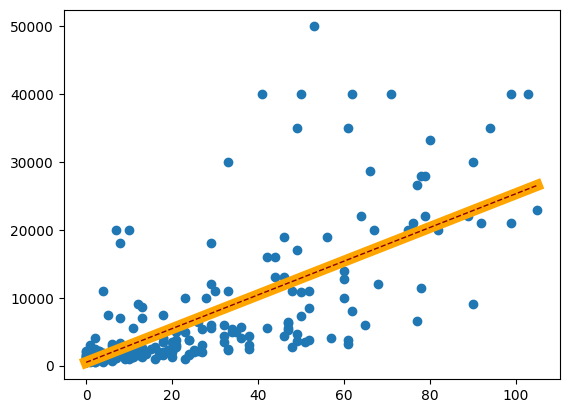

In [15]:
# パラメータを使った1次関数
def calc(x):
    return p0 + p1 * x

# 打点（X）の最小値～最大値の範囲で値を100個作成してリストに格納する
X_simu = np.linspace(X.min(), X.max(), 100)

# パラメータを使った1次関数による値
Y_simu = calc(X_simu)

# 線形回帰モデルによる予測値
Y_prd2 = linear_model.predict(X_simu.reshape(-1,1))

# １次関数：赤い点線、予測値：オレンジ、実際の値：青い散布図
plt.plot(X_simu, Y_prd2, color='orange', linewidth=8)
plt.plot(X_simu, Y_simu, color='darkred', linewidth=1, linestyle='dashed')
plt.scatter(X, Y)

1変数の線形回帰モデル（対数版）
「上昇率（金額の比）」で見る場合、対数を使います。「比率」が対数によって「差」へ変換されるため、モデルの性能が上がる可能性はあります
今までのように「金額の差」が反映されるようにプロットするのではなく「金額の比」が反映されるように対数でプロットしてみます。10を底とする対数はnumpyの log10 関数を使用します

In [16]:
# 推定年俸の対数
Y_log = np.log10(Y)

# 推定年俸と対数との比較
print(Y[:5])
print(Y_log[:5])

[21000 19000 14000 11500 11000]
[4.32221929 4.2787536  4.14612804 4.06069784 4.04139269]


データセットの分割、モデルの作成～予測までは先ほどと同様です。Y_logを使うことに注意しましょう。対数を取ると対応は非線形になってしまいますが、モデルは引き続き LinearRegression を使用できます

In [17]:
# データセットの分割。Y_logを使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

# モデルの作成～予測
log_model = LinearRegression()
log_model.fit(X_train, Y_train)
Y_pred = log_model.predict(X_valid)

In [18]:
# 対数から金額に戻す,対数のままだと先ほどのMSEと比較できないため、金額に戻してから計算
Y_valid_org = np.power(10, Y_valid) #np.powerで対数から金額へ、10は10を底にした対数にしていたから
Y_pred_org = np.power(10, Y_pred)

# MSEを算出
log_model_mse = mean_squared_error(Y_valid_org, Y_pred_org)
print('MSE(1変数の線形回帰モデル～対数版):', log_model_mse)

MSE(1変数の線形回帰モデル～対数版): 76734989.36897749


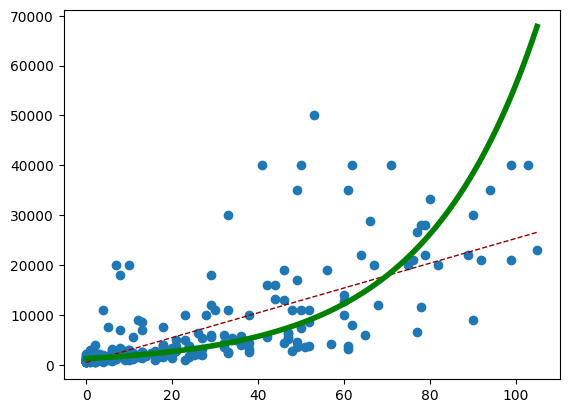

In [20]:
# 打点（X)の最小値～最大値の範囲で値を100個作成してリストに格納する
X_simu = np.linspace(X.min(), X.max(), 100)

# 線形回帰モデルによる予測値
Y_prd1 = linear_model.predict(X_simu.reshape(-1,1))

# 線形回帰モデル（対数版）による予測値
Y_prd2 = log_model.predict(X_simu.reshape(-1,1))
Y_prd2 = np.power(10, Y_prd2)

# １次関数：赤い点線、予測値：緑、実際の値：青い散布図
plt.plot(X_simu, Y_prd1, color='darkred', linewidth=1, linestyle='dashed')
plt.plot(X_simu, Y_prd2, color='green', linewidth=4, linestyle='solid')
plt.scatter(X, Y)

多項式モデル
一次関数ではパラメータの数が限られているため学習にも限界があります。そこで数式の 次元 を増やすことでパラメータの数を増やし学習性能を上げられないか試してみましょう。二次関数以上の式を使ったモデルを 多項式モデル と呼びます
パラメータの数が増えても、最適なパラメータは勾配降下法で求められることに変わりありません。次数は自分で適宜決めてかまいません。ただし次数が上がるとパラメータの数も増えるため、学習データの特徴を過度に学習してしまう「過学習」の状態へなりやすいことに注意が必要
今回は5次元の多項式モデルを作成してみます。打点の2～5乗を新たな説明変数として追加します。流れとしては、X を1次元配列に変換したものを用意し、それを2〜5乗したものをそれぞれ別の列として追加する（5列の配列を作成する）、というイメージです。また、モデルは引き続き LinearRegression を使用

In [22]:
# 以下の操作用に1次元配列に変換する
X2 = X.reshape(-1)
print(X2)

# pointsの2～5乗を新たな説明変数として追加
# np.stack()はndarrayを連結する関数
# axis:結合する次元を指定。1は列
X2 = np.stack([X2, X2**2, X2**3, X2**4, X2**5], axis=1)

# 形状を確認
print("Y=", Y.shape, ", X2=", X2.shape)

[ 92  56  60  78  48  90  12  77  35  49   8  26   2  27  13   2  11   3
   0   0   0   2  62  41  79   5  23  38  24  61  33  38  20  25   9   5
   0  24  17   0   1   1   0   0  94 105  60  52  62  50  11  52   1  11
  20   3  12   1   0   1   2   4  61  33  77  76  46  27  47   6   6  10
  20  15   2   0   7   8   0   2   1  29  49  29   8  42  36  49   8  13
   0  17   1  10  18   7  11  11   4   2   0   3   1   2   1   1  80  78
   4  38  29  32  34  11  25   5   8  12   7   0  13   7   7  16   5   1
   1  50  71 103  99  64   7   8  42  23  13  18   2  51  20  16   8   5
   0   2   1   0  53  79  89  99  46  30  34  57  18  61  48   9  13   4
   4   4   4  75  82  10  33  60  28  47  65  47  32  21   1   4   7  11
   2   9   0   0  49  66  68  50  26  47  38  21  21  19  18  13  14   1
   2   2   0  90  67  44  13  18  29  46  10  33   3   1  24  20  10   3
   2   6   0   0   1  44  52  36  21  24  32  18  27   9  13  19   4   6
  11   3   1  23   2   0   0]
Y= (241,) , X2= (241,

In [23]:
# データセットの分割。X2を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

# モデルの作成～予測
linear_model2 = LinearRegression()
linear_model2.fit(X_train, Y_train)
Y_pred = linear_model2.predict(X_valid)

# MSEを算出
liner_model2_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(多項式モデル):', liner_model2_mse)

MSE(多項式モデル): 66191888.98756776


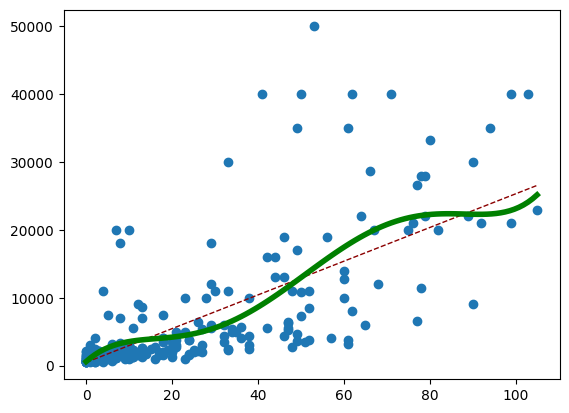

In [25]:
# 打点（X)の最小値～最大値の範囲で値を100個作成してリストに格納する
X_simu = np.linspace(X.min(), X.max(), 100)
X_simu2 = np.stack([X_simu, X_simu**2, X_simu**3, X_simu**4, X_simu**5], axis=1)

# 線形回帰モデルによる予測値
Y_prd1 = linear_model.predict(X_simu.reshape(-1,1))
# 線形回帰モデルによる予測値
Y_prd2 = linear_model2.predict(X_simu2)

# １次関数：赤い点線、予測値：緑、実際の値：青い散布図
plt.scatter(X, Y)
plt.plot(X_simu, Y_prd1, color='darkred', linewidth=1, linestyle='dashed')
plt.plot(X_simu, Y_prd2, color='green', linewidth=4, linestyle='solid')

モデルの複雑さと過学習
先ほどは5次元の多項式モデルを作成することで、1変数の線形回帰モデルの性能を超えることができました。モデルを複雑にすればパラメータの数も増え、性能が向上するはずです。
ループ文で次元の範囲を広げながら、モデルの作成と評価を行います。最後に結果のMSEをグラフにしています。MSEは学習データと検証データの2つに対して算出していることに注意してください


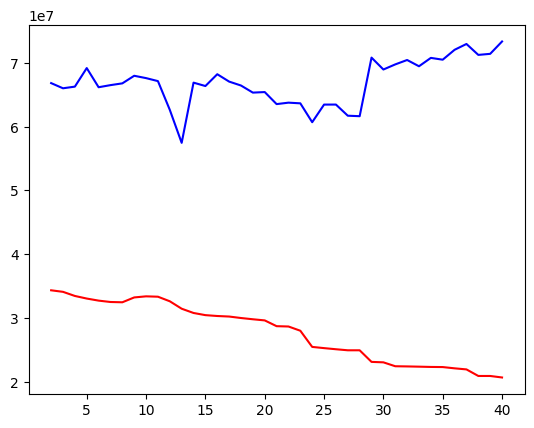

In [27]:
# MSEの結果を入れるリスト
mse_list_train = []
mse_list_valid = []

# 次元の範囲
degree = range(2, 41)

for i in degree:
    # i次元の多項式モデルを作成
    X3 = X.reshape(-1)
    X3 = np.stack([X3**j for j in range(1, i)], axis=1)

    # データセットの分割。X3を使っていることに注意
    X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=0.3, random_state=0)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

    # モデルの作成～予測
    linear_model3 = LinearRegression()
    linear_model3.fit(X_train, Y_train)

    # 学習データに対する予測とMSEの算出
    Y_pred = linear_model3.predict(X_train)
    mse = mean_squared_error(Y_train, Y_pred)
    mse_list_train.append(mse)

    # 検証データに対する予測とMSEの算出
    Y_pred = linear_model3.predict(X_valid)
    mse = mean_squared_error(Y_valid, Y_pred)
    mse_list_valid.append(mse)

# グラフの描画
plt.plot(degree, mse_list_train, color="red")
plt.plot(degree, mse_list_valid, color="blue")

横軸が次元数、縦軸はMSEの値です。赤線が学習データ、青線が検証データに対するMSEです。
学習データの方は、全体的に 右肩下がり でどこまでもMSEが小さくなっていく傾向が確認できます。それに対して検証データの方は、25次元を過ぎたあたりから逆に、 右肩上がり にMSEが増大してしまっている状況（性能の悪化）を確認できます
学習データの特徴を過度に学習したために、それ以外のデータ（検証データやテストデータ、一般的なデータ）に対するモデルの性能が悪化した状態を 過学習 と呼びます

多重線形回帰モデル
1変数（打点のみ）での予測では限界があるため、打点に加え、年数や打率などを説明変数としたモデルを作成してみましょう。2つ以上の説明変数を使ったモデルを 多重線形回帰モデル と呼びます（いわゆる 重回帰分析 と呼ばれるものも同じ意味です）
パラメータをまとめることで線形回帰モデルと同じ形の式で表現できました。もちろん多重線形回帰モデルも、最適なパラメータは勾配降下法で求められます

In [28]:
# 目的変数（Y）：推定年俸:salary
# 説明変数（X）：打点:points, 年数:years_exp, 打率:batting, 本塁打:homerun, 球団勝率:team_win
X4 = np.array(dataset[['points', 'years_exp', 'batting', 'homerun', 'team_win']])

# 形状を確認
print("Y=", Y.shape, ", X4=", X4.shape)

Y= (241,) , X4= (241, 5)


In [29]:
# データセットの分割。X4を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

# モデルの作成～予測
general_model = LinearRegression()
general_model.fit(X_train, Y_train)
Y_pred = general_model.predict(X_valid)

# MSEを算出
general_model_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(多重線形回帰モデル):', general_model_mse)

MSE(多重線形回帰モデル): 59313342.14717217


Lasso回帰、Ridge回帰
線形回帰モデルに 正則化 という過学習を防ぐ仕組みを取り入れたものです。正則化には L1正則化 と L2正則化 の2つがあります。

L1正則化：余計な説明変数を削除するようパラメータが調整される
L2正則化：パラメータが大きくなるのを防ぎ過学習を抑制する
Lasso回帰はL1正則化を取り入れたもの、Ridge回帰はL2正則化を取り入れたもので、単なる線形回帰モデルより過学習を起こしにくいと言われています。

In [30]:
# Lasso回帰
from sklearn.linear_model import Lasso

# データセットの分割。X4を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

# モデルの作成～予測
lasso_model = Lasso()
lasso_model.fit(X_train, Y_train)
Y_pred = lasso_model.predict(X_valid)

# MSEを算出
lasso_model_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(Lasso回帰):', lasso_model_mse)

MSE(Lasso回帰): 59325970.95844398


In [31]:
# Ridge回帰
from sklearn.linear_model import Ridge

# データセットの分割。X4を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

# モデルの作成～予測
ridge_model = Ridge()
ridge_model.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_valid)

# MSEを算出
ridge_model_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(Ridge回帰):', ridge_model_mse)

MSE(Ridge回帰): 59881176.93127864


回帰木
分類モデルで使用されることが多い決定木を回帰に応用したのが回帰木です

In [32]:
# 決定木
from sklearn.tree import DecisionTreeRegressor

# データセットの分割。X4を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, Y_train)
Y_pred = tree_model.predict(X_valid)

tree_model_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(回帰木):', tree_model_mse)

MSE(回帰木): 91188733.33333333


ランダムフォレスト
決定木を複数組み合わせたランダムフォレストを回帰に応用したもの

In [33]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor

# データセットの分割。X4を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

randomforest_model = RandomForestRegressor(n_estimators=10, random_state=0)
randomforest_model.fit(X_train, Y_train)
Y_pred = randomforest_model.predict(X_valid)

randomforest_model_mse = mean_squared_error(Y_valid, Y_pred)
print('MSE(ランダムフォレスト):', randomforest_model_mse)

MSE(ランダムフォレスト): 76453938.74509804


モデルと説明変数の選択
多重線形回帰モデルでは5つの説明変数を使ってモデルを作成しました。それでは最適なモデルと説明変数の組み合わせはどのように見つけたら良いでしょうか。単純な方法として、モデルごとにすべての説明変数の組み合わせを総当りで比較する、という方法があります。
まずはすべての説明変数名の組み合わせのリストを作成しましょう。組み合わせを得るには itertools.combinations を使用すると便利です


In [42]:
# 総当りで最良のMSEを算出する関数
import itertools

def get_best_features(x, y, feature_names, model):
    # すべての説明変数名の組み合わせを入れるリスト
    _name_list = []

    # 指定された長さの組み合わせを作成する
    for i in range(1, len(feature_names)+1):
        for sublist in itertools.combinations(feature_names, i):
            _name_list.append(list(sublist))

    # 最良のMSEを入れる変数（大きい値を入れておく）
    _best_mse = 999999999999
    _best_mse_name = ''

    # 総当りで比較する
    for _name in _name_list:
        _x = np.array(x[_name])

        _x_train, _x_test, _y_train, _y_test = train_test_split(_x, y, test_size=0.3, random_state=0)
        _x_train, _x_valid, _y_train, _y_valid = train_test_split(_x_train, _y_train, test_size=0.3, random_state=0)

        # モデルの作成～予測
        model.fit(_x_train, _y_train)
        _y_pred = model.predict(_x_valid)

        # MSEを算出
        _mse = mean_squared_error(_y_valid, _y_pred)

        # 最小のmseを保管
        if _mse < _best_mse:
            _best_mse = _mse
            _best_mse_name = _name

    print(model.__class__.__name__, ":", ','.join(_best_mse_name), ": MSE=", _best_mse)

In [35]:
# 説明変数名のリスト
feature_names = ['points', 'years_exp', 'batting', 'homerun', 'team_win']

# モデルのリストを用意
model_list = []
model_list.append(LinearRegression())
model_list.append(Lasso())
model_list.append(Ridge())
model_list.append(DecisionTreeRegressor())
model_list.append(RandomForestRegressor(n_estimators=100, random_state=0))

for model in model_list:
    get_best_features(dataset, Y, feature_names, model)

LinearRegression : points,years_exp,homerun,team_win : MSE= 59272503.230480626
Lasso : points,years_exp,homerun,team_win : MSE= 59290453.09974449
Ridge : points,years_exp,homerun,team_win : MSE= 59866522.48342749
DecisionTreeRegressor : points,years_exp,batting,homerun : MSE= 69615223.52941176
RandomForestRegressor : years_exp,batting,homerun,team_win : MSE= 75322931.14117648


意外なことに線形回帰モデルのMSEが最小になりました。説明変数は「points,years_exp,homerun,team_win」の組み合わせが最良のようです。今回は単純にすべての説明変数の組み合わせを比較しましたが、より効率よく、説明変数の組み合わせを増やしながら性能が出るものだけを選んでいく 変数増加法 や、逆に説明変数の組み合わせを減らしていく 変数減少法 などもあります

パラメータのチューニング
モデルの設定値を変えて性能向上を目指すことをチューニングと呼びます。ここでは先ほどもっとも性能が悪かったランダムフォレストの性能がどこまで上がるか、パラメータをチューニングして確認してみます
モデルによって異なりますが、パラメータは複数存在します。scikit-learn の GridSearchCV を使用すると、すべてのパラメータの組み合わせから総当りで最良のものを選択してくれます
ランダムフォレストのパラメータには n_estimators（木の数） や max_depth（木の深さ） などがあります。これらを指定してみましょう。



In [36]:
from sklearn.model_selection import GridSearchCV

# モデル:ランダムフォレスト
model = RandomForestRegressor(random_state=0)

# パラメータ:n_estimators:木の数、max_depth:木の深さ
params = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 50]}

# グリッドサーチの設定
# cv:交差検証の回数, scoring:目的変数
gscv = GridSearchCV(model, param_grid=params, cv=3, scoring='neg_mean_squared_error')

学習データには、ランダムフォレストで性能が良かった説明変数の組み合わせを指定します。今回は交差検証なので、機械学習用データを学習データと検証データへ分けずにそのまま指定します。

In [37]:
# ランダムフォレストで性能が良かった説明変数の組み合わせを指定
X5 = np.array(dataset[['years_exp', 'homerun', 'team_win', 'batting']])

# データセットの分割。X5を使っていることに注意
X_train, X_test, Y_train, Y_test = train_test_split(X5, Y, test_size=0.3, random_state=0)

In [38]:
# fit 関数で学習を通じて最適なパラメータの組み合わせを選び出します
# 学習を実施
gscv.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 50],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_mean_squared_error')

In [39]:
# MSE
gscv.best_score_

np.float64(-53609831.652131505)

In [40]:
#最適なパラメータの組み合わせは best_params_ で取得
# 最適なパラメータ
gscv.best_params_


{'max_depth': 10, 'n_estimators': 50}

テストデータによる評価
ここまでで、最適な「モデル・説明変数・パラメータ」の組み合わせが得られました。最後にテストデータを用いてモデルの汎化性能を評価しましょう

In [41]:
# 最適なパラメータによる学習
randomforest_model = RandomForestRegressor(**gscv.best_params_)
randomforest_model.fit(X_train, Y_train)

# テストデータによる評価
Y_pred = randomforest_model.predict(X_test)

randomforest_model_mse = mean_squared_error(Y_test, Y_pred)
print('MSE(ランダムフォレスト):', randomforest_model_mse)

MSE(ランダムフォレスト): 52568306.426380225
